In [1]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import warnings
# import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
import datetime

warnings.filterwarnings( 'ignore' )

# 0.0 Imports

## 0.1. Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ): # verbose serve para se queremos que printe cada interaçao da funçao do kfold 
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] ) # np.round faz mesma coisa do .2f em c e aqui em python

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y )
    cm = cm.values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] ) # rmse mede o erro 

## 0.2.Loading data

In [3]:
df_sales_raw = pd.read_csv( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/datasets/store.csv', low_memory=False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0 Descriçao dos dados

In [4]:
def jupyter_settings():    
    sns.set()
jupyter_settings()

In [5]:
# Sempre que mudar de secao da um .copy(), pois ajuda quando a gente ta navegando em um notebook mt grande
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
df1.columns


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
# cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
#        'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
#        'CompetitionDistance', 'CompetitionOpenSinceMonth',
#        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
#        'Promo2SinceYear', 'PromoInterval']

# snakecase = lambda x: inflection.underscore( x )

# #fazer o mapeamento da nossa funçao snakecase em todas as minhas cols_old
# cols_new = list( map( snakecase, cols_old ) )

cols_new = [ 'store','day_of_week','date','sales','customers','open','promo','state_holiday','school_holiday','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year','promo2','promo2_since_week','promo2_since_year','promo_interval' ]

# renaming
df1.columns = cols_new

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [8]:
print( 'number of Rows: {}'.format( df1.shape[0] ) )
print( 'number of Rows: {}'.format( df1.shape[1] ) )


number of Rows: 1017209
number of Rows: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
# competition_distance( vamos supor que ta na pq a distancia é mt grande de outra loja )
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: (df1['competition_distance'].max())*10 if math.isnan( x ) else x )


# competition_open_since_month( vamos copiar a data de venda da loja para essa coluna )
df1['competition_open_since_month'] = df1.apply ( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )


# competition_open_since_year
df1['competition_open_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )


# promo2_since_week
df1['promo2_since_week'] = df1.apply ( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )



# promo2_since_year
df1['promo2_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo_interval
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [12]:

df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [13]:
df1['competition_distance'].max()

758600.0

In [14]:
df1.sample(5).T # transposto(inverte linha e coluna)

,84107,621625,503730,704699,855717
store,483,241,536,805,183
day_of_week,7,6,7,2,6
date,2015-05-17 00:00:00,2013-12-21 00:00:00,2014-04-06 00:00:00,2013-10-08 00:00:00,2013-05-25 00:00:00
sales,0,9131,0,7595,3016
customers,0,914,0,687,423
open,0,1,0,1,1
promo,0,0,0,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,d,a,d,a


## 1.6 Change Types
    - ( sempre que a gente faz uma alteraçao nas colunas, como foi preencher os dados faltantes, a gente tem qeu checar se esta tudo ok com os tipos )

In [15]:
print( df1.dtypes )


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object


In [113]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )


## 1.7 Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )


### 1.7.1 Numerical Attributes

In [18]:
# Central Tendency -  mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skev, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T # Esse T é para uma vermos melhor o dataset
d2 = pd.DataFrame( num_attributes.apply( min ) ).T # Esse T é para uma vermos melhor o dataset
d3 = pd.DataFrame( num_attributes.apply( max ) ).T # Esse T é para uma vermos melhor o dataset
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T # Esse T é para uma vermos melhor o dataset
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T # Esse T é para uma vermos melhor o dataset
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis ) ).T # Esse T é para uma vermos melhor o dataset

# concatenate
dfDesc = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d4 ] ).T.reset_index()

dfDesc.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [19]:
print(dfDesc)

                      attributes     min       max     range         mean  \
0                          store     1.0    1115.0    1114.0   558.429727   
1                    day_of_week     1.0       7.0       6.0     3.998341   
2                          sales     0.0   41551.0   41551.0  5773.818972   
3                      customers     0.0    7388.0    7388.0   633.145946   
4                           open     0.0       1.0       1.0     0.830107   
5                          promo     0.0       1.0       1.0     0.381515   
6                 school_holiday     0.0       1.0       1.0     0.178647   
7           competition_distance    20.0  758600.0  758580.0  7386.296140   
8   competition_open_since_month     1.0      12.0      11.0     6.786849   
9    competition_open_since_year  1900.0    2015.0     115.0  2010.324840   
10                        promo2     0.0       1.0       1.0     0.500564   
11             promo2_since_week     1.0      52.0      51.0    23.619033   

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

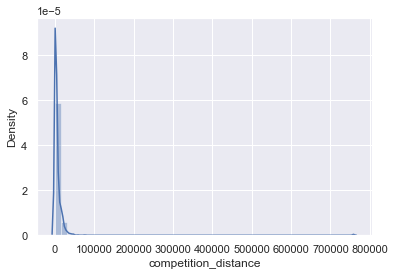

In [20]:
sns.distplot( df1['competition_distance'] )

### 1.7.2 Categorical Attributes

In [21]:
# cat_attributes.apply( lambda x: x.unique.shape[0] )

<AxesSubplot:xlabel='store_type', ylabel='sales'>

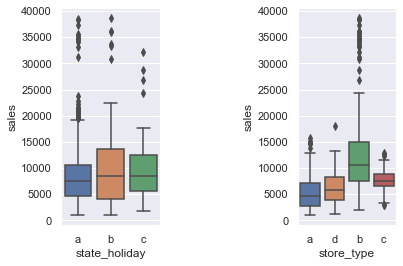

In [22]:
aux1 = df1[ ( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )] # para tirar os que nao tem vendas ou nao tem estaçao

plt.subplot( 1,3,1 )
sns.boxplot( x='state_holiday' , y='sales' , data=aux1 )

plt.subplot( 1,3,3 )
sns.boxplot( x='store_type' , y='sales' , data=aux1 )

# plt.subplot( 1,3,2 )
# sns.boxplot( x='assortment' , y='sales' , data=aux1 )

#o grafico é dividido em quartis, senod o do meio o 75  e25, a linha representa a mediana quartil 50
# video do meigarom representa mt bem o que a  gente deve olhar quando ver esse tipo de grafico
# modulo 2 , video 3

# 2.0 Feature Engineering

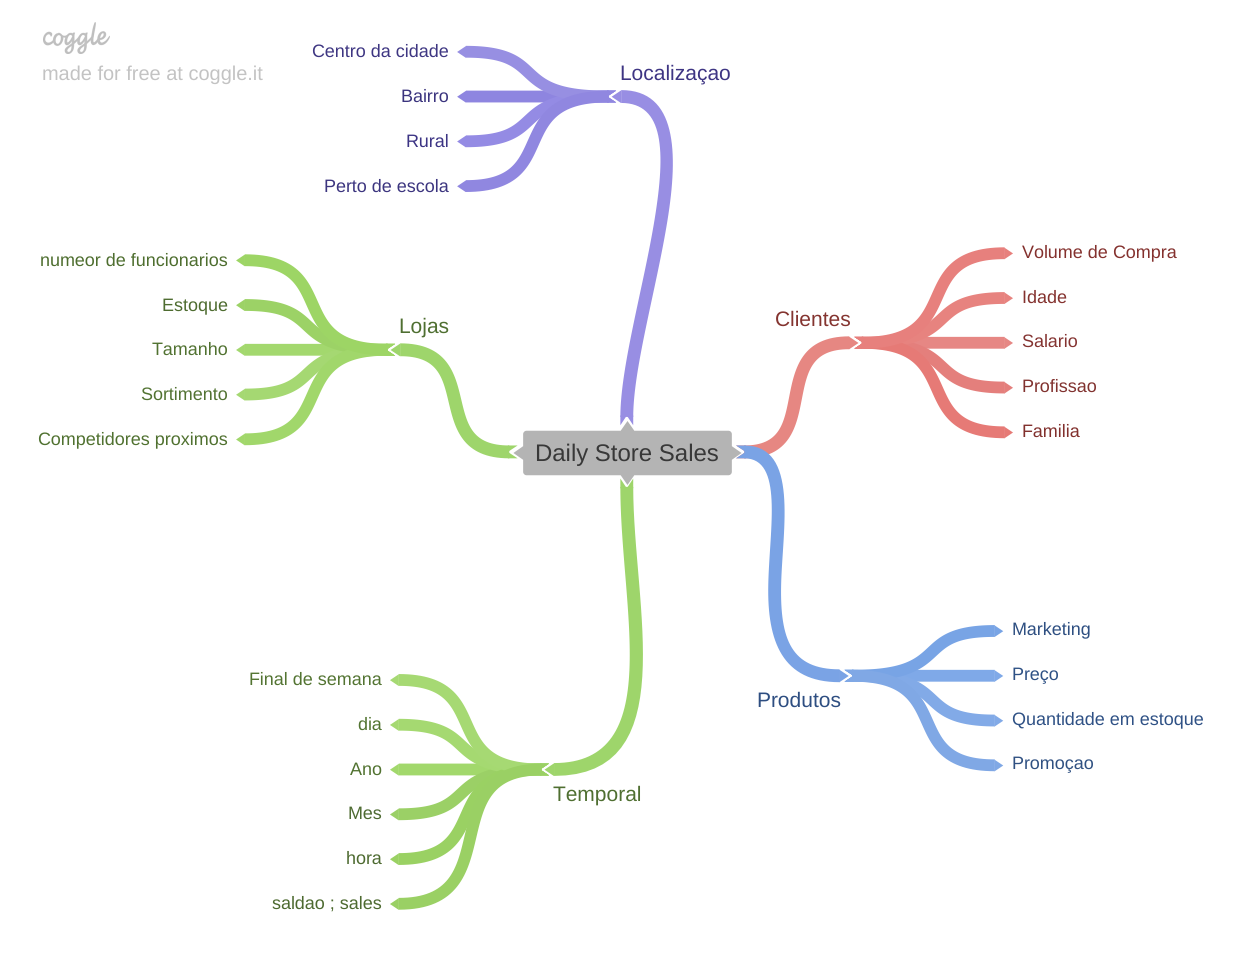

In [23]:
df2 = df1.copy()
Image( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/img/MindMapHypothesis.png' )

## 2.1 Mapa Mental de Hipoteses( Criaçao das hipoteses )


In [24]:
### 2.1.1 Hipoteses Loja


**1.** Lojas com número maior de funcionários deveriam vender mais.( nao tenho numero de funcionarios nesse dataset )

**2.** Lojas com maior capacidade de estoque deveriam vender mais.( nao tenho inf do estoque )

**3.** Lojas com maior porte deveriam vender mais.( nao tenho porte da loja )

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.


### 2.1.2 Hipoteses Produto


**1.** Lojas que investem mais em Marketing deveriam vender mais.( nao tenho despesas(budget) do marketing )

**2.** Lojas com maior exposição de produto deveriam vender mais.( nao  tenho quantidade de produtos com exposiçao )

**3.** Lojas com produtos com preço menor deveriam vender mais.( nao tenho preço dos produtos )

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.( nao temos categorias das promoçoes )

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.


### 2.1.3 Hipotesese Tempo


**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.


## 2.2 Lista Final de Hipoteses

#### Lista final Loja


**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.


#### Lista final Produto


**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.


#### Lista final Tempo


**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.



## 2.3 Feature Engineering

In [25]:

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# # competition since
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype( int )
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype( int )
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


# promo since
df2['promo2_since_week'] = df2['promo2_since_week'].astype( int )
df2['promo2_since_year'] = df2['promo2_since_year'].astype( int )
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )



In [26]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

In [27]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [28]:
print(df2.dtypes)

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# 3.0 Filtragem de variáveis

In [29]:
df3 = df2.copy()

In [30]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [31]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleçao das Colunas

In [32]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
# axis 0 => linhas
# axis 1 => colunas
df3 = df3.drop( cols_drop, axis=1 )


In [33]:
df3.columns


Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Analise Exploratoria dos Dados

In [34]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Respose Variable

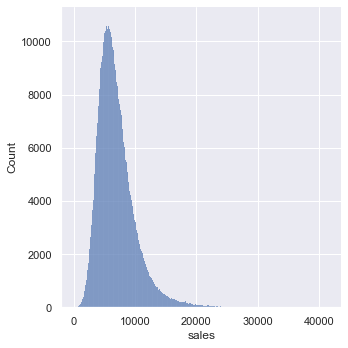

In [35]:
sns.displot( df4['sales'] )# ta pequeno os numeros no eixo y pq isso é uma plot de densidade da distribuiçao se quisermos tirar a linha que contorna é so colocar kde=False

### 4.1.2 Numerical Variable

<Figure size 3600x360 with 0 Axes>

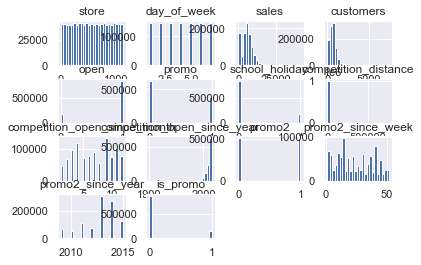

In [36]:
plt.figure( figsize=( 50, 5 ) )
num_attributes.hist( bins=25 );

### 4.1.3 Categorical Variable

In [37]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

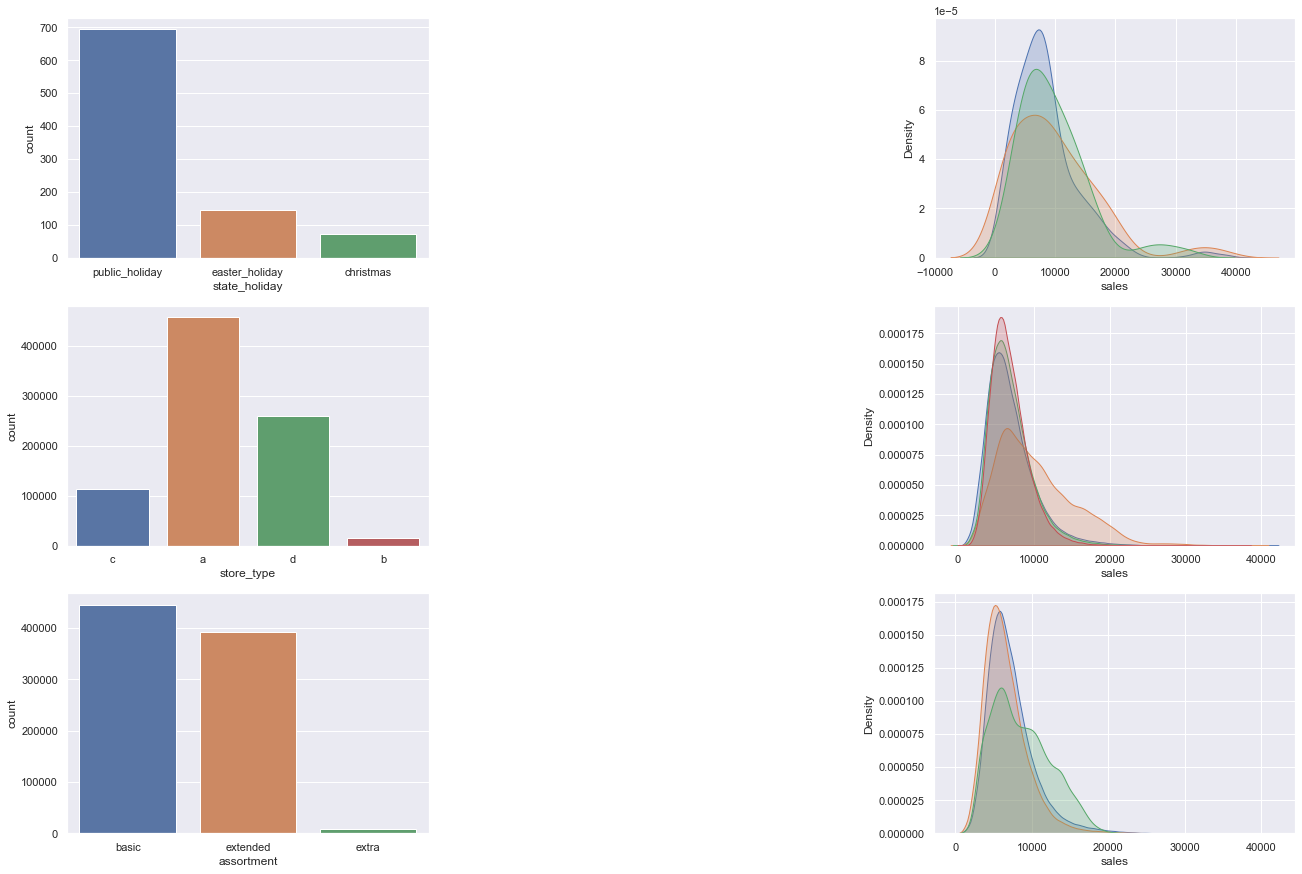

In [38]:
plt.figure( figsize=( 22, 15 ) )
# state_holiday
plt.subplot( 3, 3, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 3, 3 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 3, 4 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 3, 6 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 3, 7 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 3, 9 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 4.2 Analise Bivariada

### **H1.** Lojas com maior sortimentos( mix de produtos ) deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.<p>
**É importante pro modelo?** Sim, pois mesmo que o basic e o extended sejam semelhantes, o extra tem um comportamento peculiar que vale a pena treinar o modelo com ele.

<AxesSubplot:xlabel='year_week'>

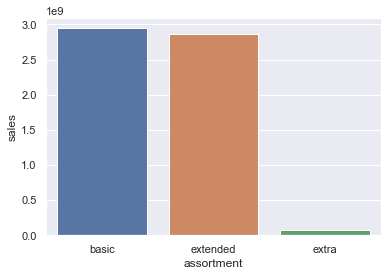

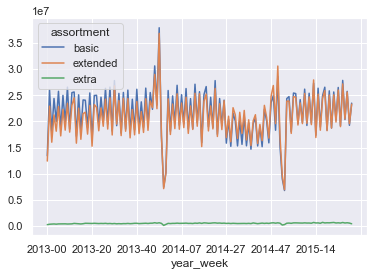

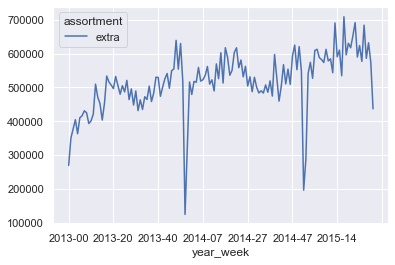

In [39]:
aux1 = df4[['assortment','sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week','assortment','sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux3 = aux2.pivot( index='year_week', columns='assortment', values='sales' )
aux3.plot()

aux4 = aux2[ aux2['assortment'] == 'extra' ]
aux5 = aux4.pivot( index='year_week', columns='assortment', values='sales' )
aux5.plot()

In [40]:
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


In [41]:
aux3.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061


### **H2.** Lojas com competidores mais próximos deveriam vender menos.( senso comum )
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.<p>
**É importante pro modelo?** pode ser importante para o modelo, mas de uma forma mais fraca

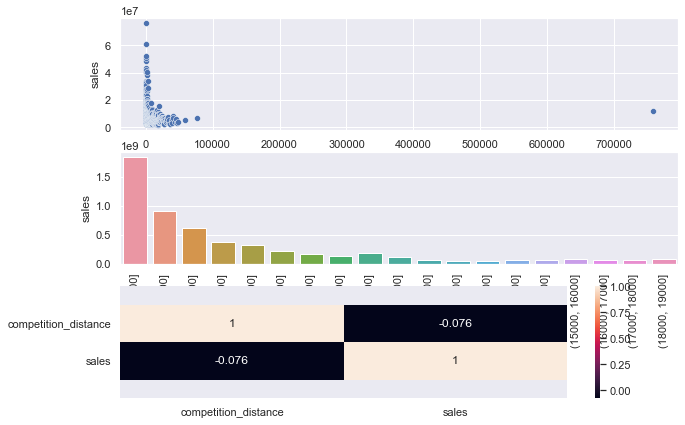

In [42]:
plt.figure( figsize=( 10, 7 ) )
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 3, 1, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 3, 1, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 3, 1, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );# ver a correlaçao das distancias e das vendas
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

In [43]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
586,18650.0,5608306,"(18000, 19000]"
342,4880.0,12159505,"(4000, 5000]"
340,4840.0,5167478,"(4000, 5000]"
486,10180.0,4064054,"(10000, 11000]"


### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**Falsa** Lojas com competidores a mais tempo vendem menos, bem contraintuitivo

**É importante para o modelo?** pode ser, mas nem tanto, pearson fraco

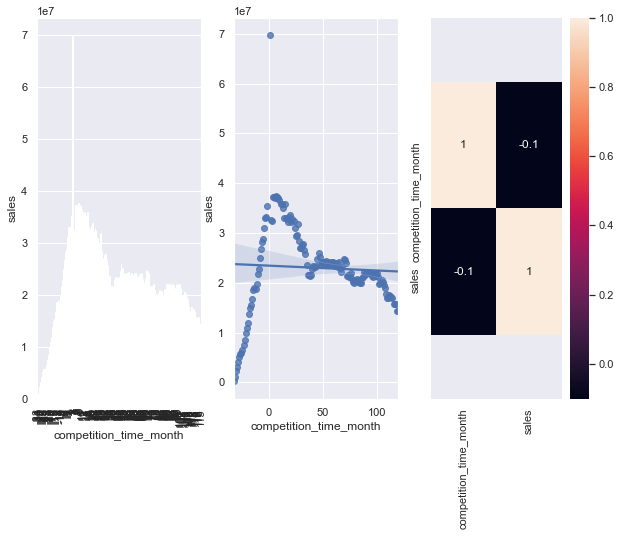

In [44]:
plt.figure( figsize=( 10, 7 ) )
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

In [45]:
df4.columns


Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

### H4 .Lojas com maior sortimentos deveriam vender mais.
**False** pois lojas com promoçoes ativas por amis tempos vendem menos, edpois de um certo periodo de promoçao 

**É importante para o modelo?** Nao, pearson baixo

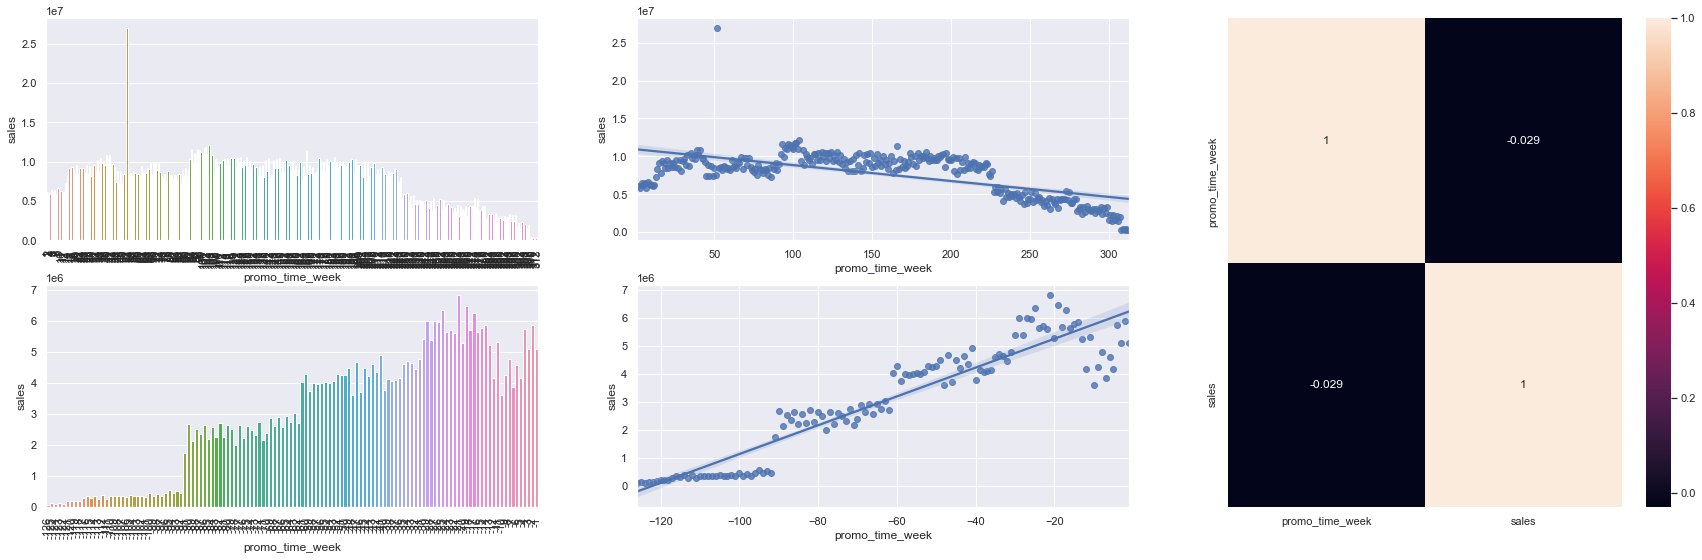

In [46]:
# granularidade -> ex: venda por dia por loja, menor porçao dos dados
plt.figure( figsize=( 30, 9 ) )

aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = plt.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s>H5. Lojas com mais dias de promoçao deveriam vender mais</s>

In [47]:
# Cara essa h5 é bem parecida com h4, 
# entao vamos deixar para o segundo ciclo do CRISP-DaS

### H7.Lojas com mais promoçoes consecutivas deveriam vender mais
- Nao é tao relevante essa hipotese para o modelo, pois é mt pouco a diferença da tradicional e extenida para a so extendida, e o comportamento estranho que poderia ser analisado pelo modelo é mt pequeno entao nem deve influenciar, depois pegamos opiniao de um algoritmo

**Falsa** Lojas com mais promoçoes consecutivas vendem menos

**É importante para o modelo?** Deve sim, tem um fenomeno que do nada cai o modo tradicional, que pode ser importante para o modelo aprender

In [48]:
df4[['promo','promo2','sales']].groupby( ['promo','promo2'] ).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


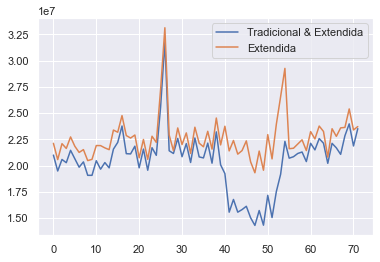

In [49]:

aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);


### **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**Falsa** Lojas abertas durante o feriado de natal vendem menos

- Ja é algo conhecido, nao é um insight

**É importante para o modelo?** Sim, pois se for feriado muda como que o modelo tem que prever

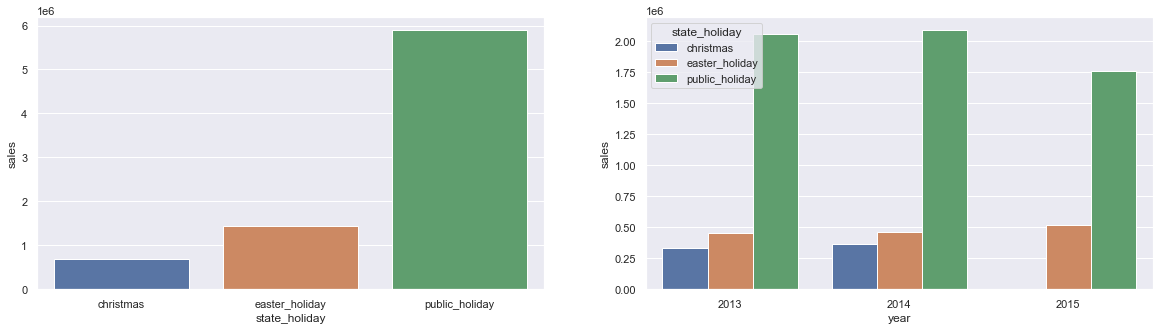

In [50]:
plt.figure( figsize=( 20, 5 ) )
plt.subplot( 1,2,1 )
aux = df4[ df4['state_holiday'] != 'regular_day' ]
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1,2,2 )
aux2 = aux[['year','state_holiday', 'sales' ]].groupby( [ 'year', 'state_holiday' ] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### **H9.** Lojas deveriam vender mais ao longo dos anos.
**False** Lojas vendem menos ao longo dos anos

- No é insight, pois as pessoas ja devem saber
- Sempre comparar entre periodos fechados, posi senao vai da um problema na sua naalise, ja qeu nao tem todos os daddos daquele periodo

**É importante para o modelo?** Sim, altissima correlaçao

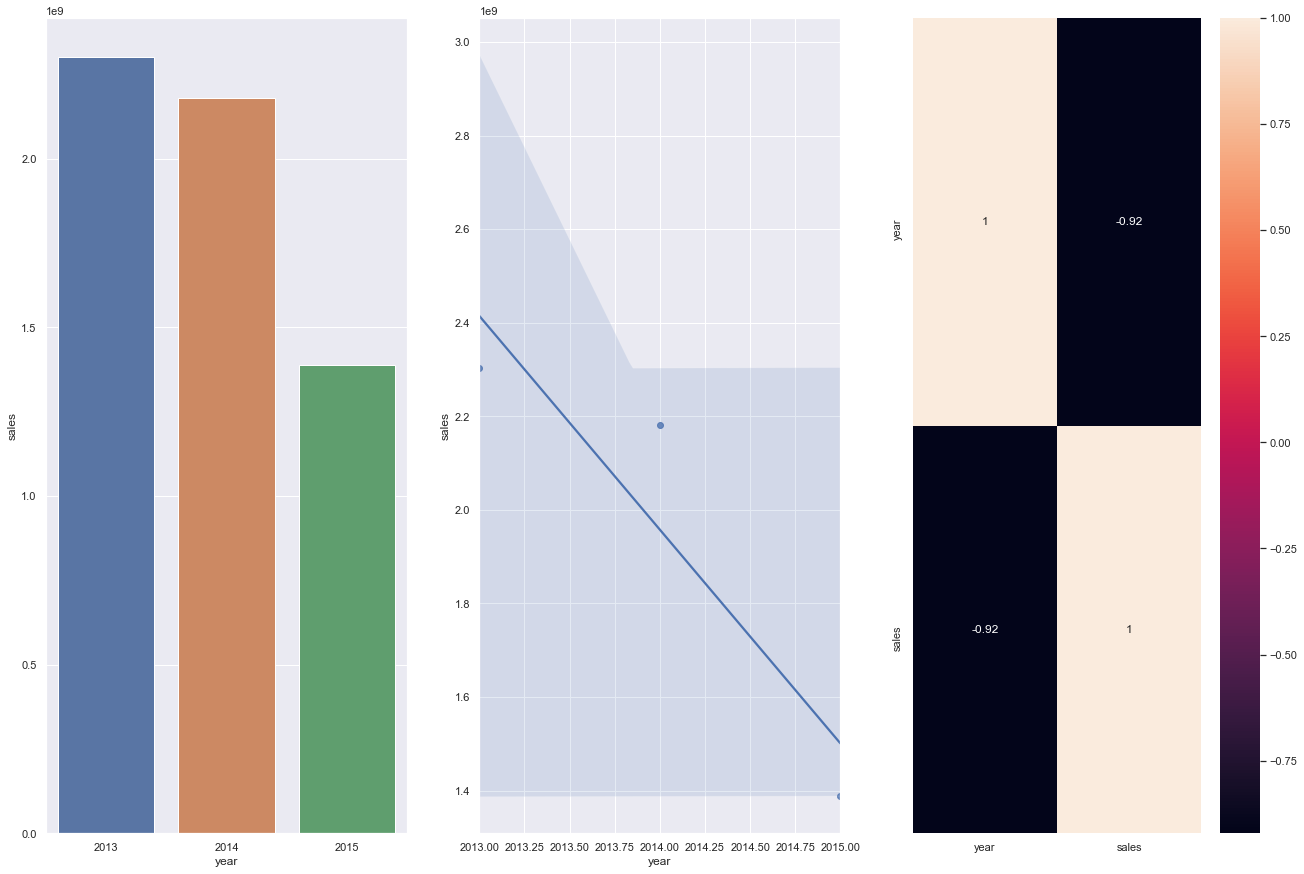

In [51]:
plt.figure( figsize=( 22, 15 ) )
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1,3,1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1,3,2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H10.** Lojas deveriam vender mais no segundo semestre do ano.

- Nao é um insight, as pessoas ja devem saber disso, nao é nem contraintutitivo nem uma informaçao nova


**É importante para o modelo?**Sim, correlaçao alta

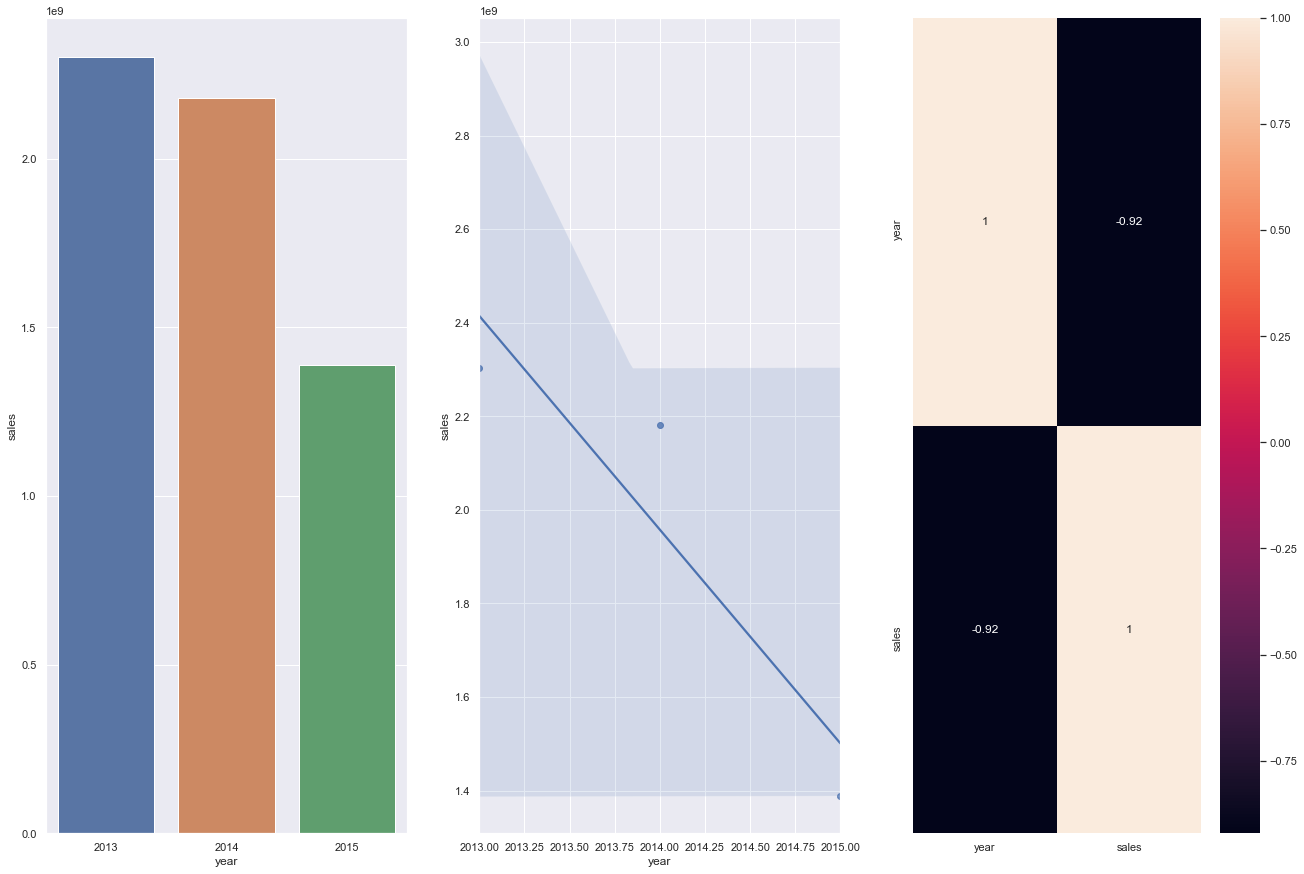

In [52]:
plt.figure( figsize=( 22, 15 ) )
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1,3,1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1,3,2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**Verdadeira** Lojas vendem mais depois do dia 10 de cada mes

- Nao é insight, pois pessoas acompanham isso ja

**É importante para o modelo?** Sim, pois tem uma certa correlaçao negativa( quanto maior um, menor outro )

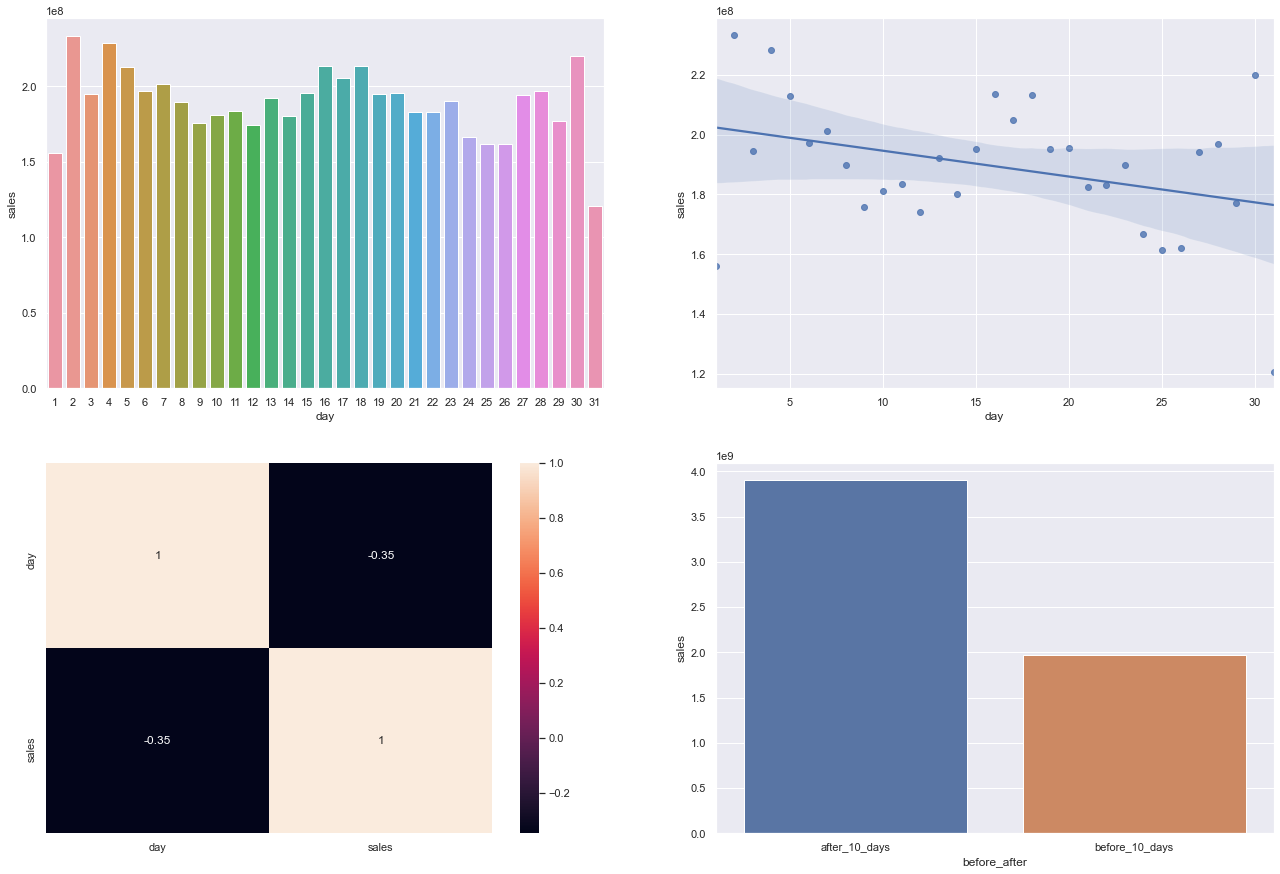

In [53]:
plt.figure( figsize=( 22, 15 ) )
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2,2,1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2,2,2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2,2,3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x<=10 else 'after_10_days' )

plt.subplot( 2,2,4 )
aux2 = aux1[['before_after','sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2 );


### **H12.** Lojas deveriam vender menos aos finais de semana.
**Verdadeira** Lojas vendem menos nos finais de semana

**É importante para o modelo?** Sim, correlaçao alta

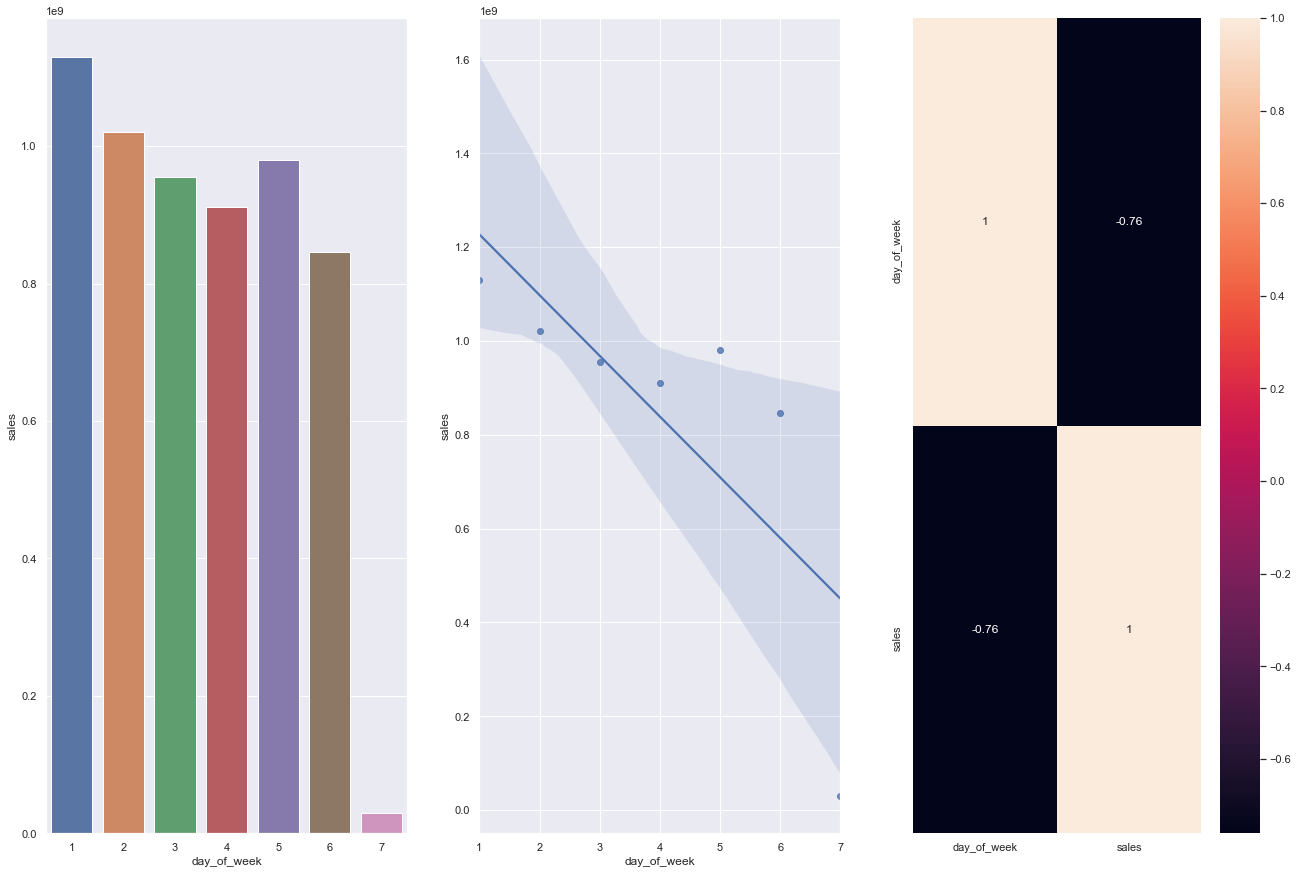

In [54]:
plt.figure( figsize=( 22, 15 ) )
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1,3,1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1,3,2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H13.** Lojas deveriam vender menos durante os feriados escolares.
**Verdadeira** Lojas vendem menos durante os feriados escolares, except os meses de Julho e Agosto

- Noa deve ser insight, o time de negoicos ja deve saber disso

**É importante para o modelo?** Sim, para modelar o algoritmo precisa saber se é feriado escolar, e que mes esta

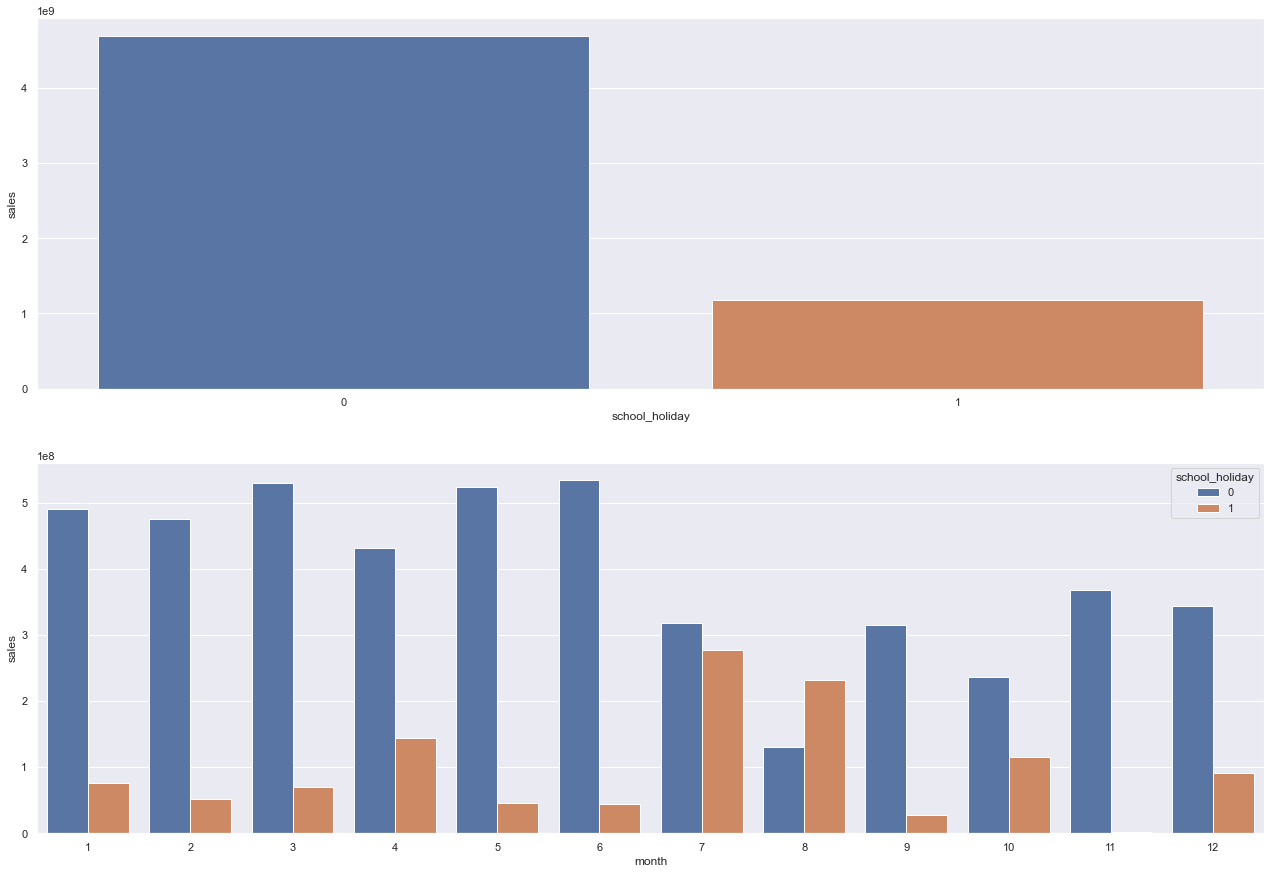

In [55]:
plt.figure( figsize=( 22, 15 ) )
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2,1,1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month','school_holiday', 'sales']].groupby([ 'month','school_holiday' ]).sum().reset_index()

plt.subplot( 2,1,2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );


## 4.2.1 Resumo das hipoteses

In [56]:
# from tabulate import tabulate

In [57]:

# tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
#       ['H1', 'Falsa', 'Baixa'],  
#       ['H2', 'Falsa', 'Media'],  
#       ['H3', 'Falsa', 'Media'],
#       ['H4', 'Falsa', 'Baixa'],
#       ['H5', '-', '-'],
#       ['H7', 'Falsa', 'Baixa'],
#       ['H8', 'Falsa', 'Media'],
#       ['H9', 'Falsa', 'Alta'],
#       ['H10', 'Falsa', 'Alta'],
#       ['H11', 'Verdadeira', 'Alta'],
#       ['H12', 'Verdadeira', 'Alta'],
#       ['H13', 'Verdadeira', 'Baixa'],
#      ]  
# print( tabulate( tab, headers='firstrow' ) )


## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

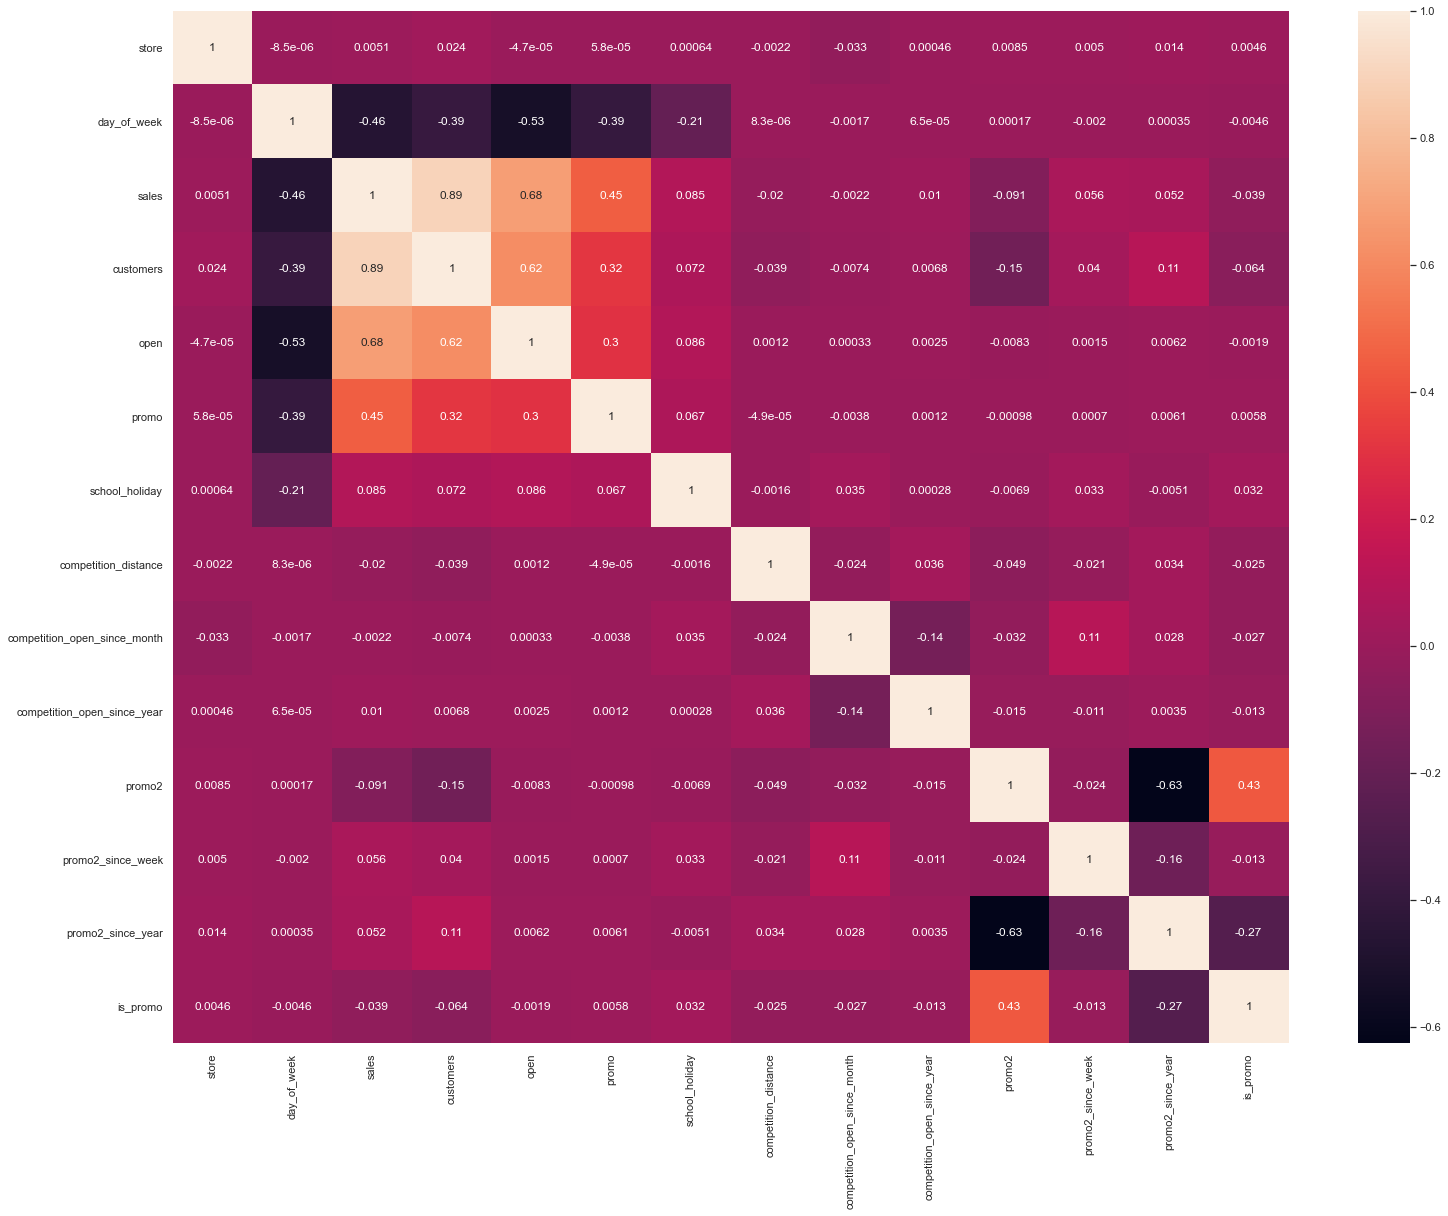

In [58]:
correlation = num_attributes.corr( method='pearson' )
plt.figure( figsize=( 25, 19 ) )
sns.heatmap( correlation, annot=True );

# Temos um problema aqui, temos por exemplo uma correlaçao alta de costumers
# com sales, mas n podemos faer nada, pois nao temos como prever quantos
# costumers vao ter nas poroximas 6 semanas, so se fizessemos um projeto separadoe depois
# Incorporasse aqui nesse projeto, Porblema supçer comum

### 4.3.2 Categorical Attributes

In [59]:
a = df4.select_dtypes( include='object' )

In [60]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [61]:
cm = pd.crosstab( a['state_holiday'], a['store_type'] )
cm = cm.values

In [62]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])


d = pd.DataFrame( {'state_holiday': [a1,a2,a3],
                   'store': [a4,a5,a6],
                   'assortment': [a7,a8,a9],    
                    })
d = d.set_index( d.columns )


In [63]:
d

,state_holiday,store,assortment
state_holiday,1.000002,0.071065,0.067546
store,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

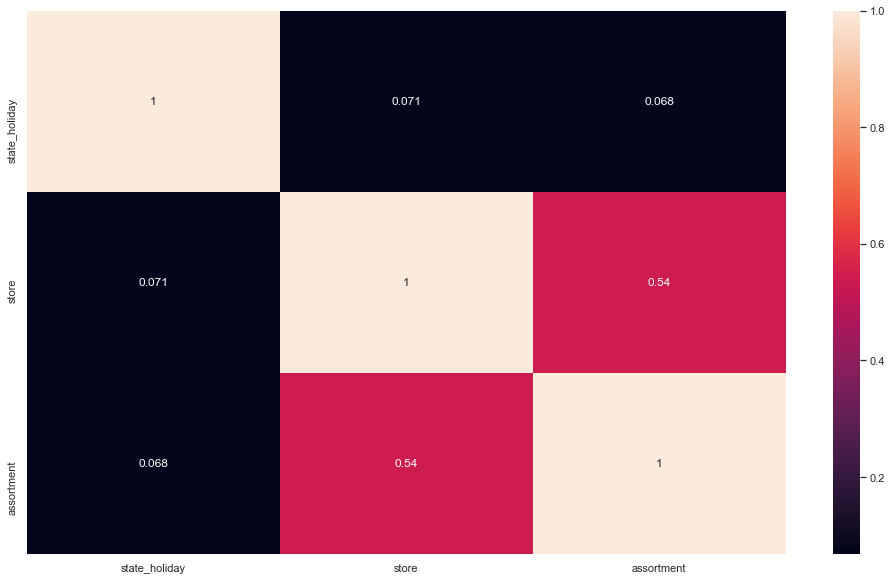

In [64]:
plt.figure( figsize=( 17, 10 ) )
sns.heatmap( d, annot=True ) # ver a correlaçao das variaveis categoricas


# 5.0 Data Preparation

In [65]:
df5 = df4.copy()

## 5.1 Normalizaçao

In [66]:
# Nao é necessario fazer, pois nenhuma variavel categorica
# tem uma distribuiçao que pareça normal por ela porpria

## 5.2 Rescaling

In [67]:
a = df5.select_dtypes( include=['int64', 'float64','int32','UInt32'] )

<AxesSubplot:xlabel='competition_distance'>

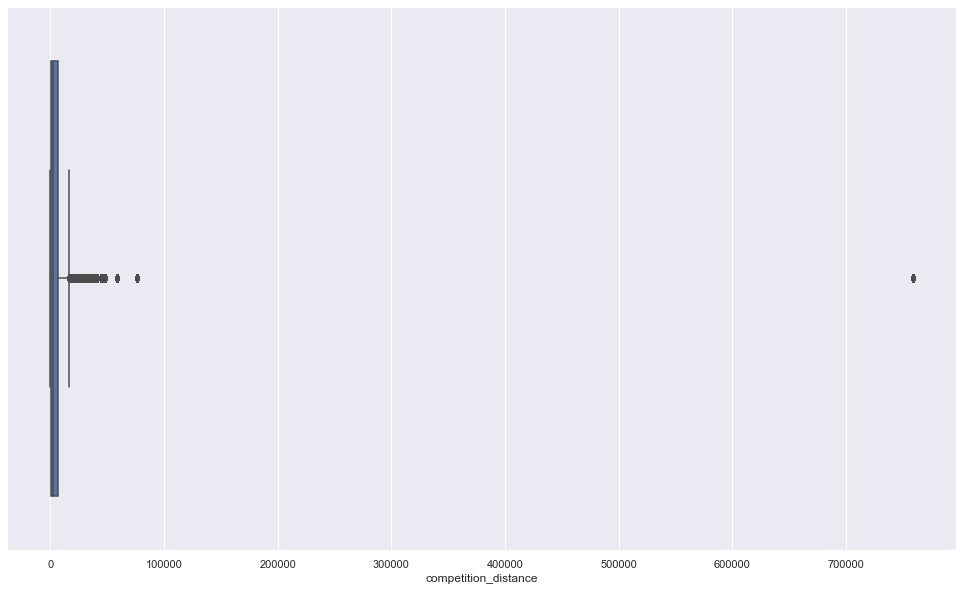

In [68]:
plt.figure( figsize=( 17, 10 ) )
sns.boxplot( df5['competition_distance'] )

In [69]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/parameters/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/parameters/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/parameters/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/parameters/year_scaler.pkl', 'wb') )

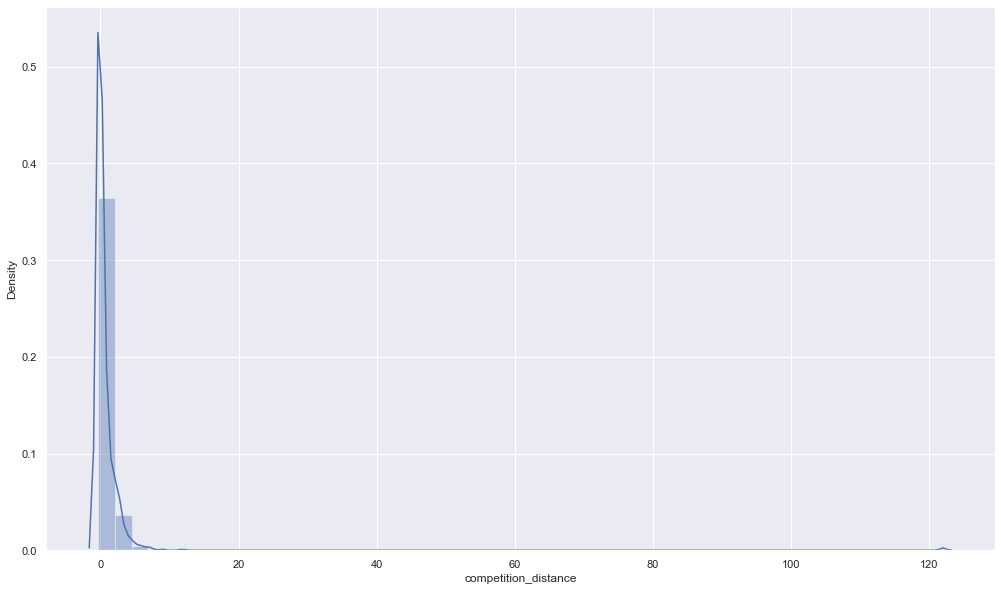

In [70]:
plt.figure( figsize=( 17, 10 ) )
sns.distplot( df5['competition_distance'] );

## 5.3 Transformaçao

### 5.3.1 Encoding

In [71]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [72]:
# state holiday( one hot encoding, estado dos dias é medido por essa variavel )
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store type( nao tem uma ordem, vamos de label encoding so trocar letra por numeros )
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/parameters/store_type_scaler.pkl', 'wb') )


df5['assortment'].drop_duplicates() # isso é para ver quais tipos tem daquela variavel categorica
# assortment( tem ordem, basic< extra <extended, usamos o ordinal encoding )
assortment_dict = { 'basic':1, 'extra':2, 'extended':3 }
df5['assortment'] =  df5['assortment'].map( assortment_dict )

### 5.3.2 Response Variable Transformation

In [73]:
df5['sales'] = np.log1p( df5['sales'] )

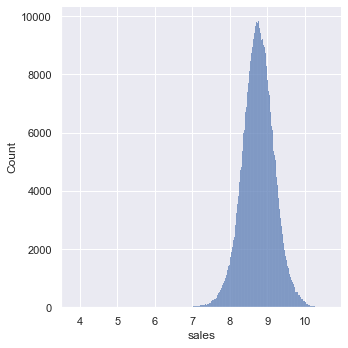

In [74]:
sns.displot( df5['sales'] )

### 5.3.3 Nature Transformation( cycle transformation )

In [75]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2 * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2 * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2 * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2 * np.pi/30 ) ) )

# Week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi/52 ) ) )                                                 
                                                    
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2 * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2 * np.pi/7 ) ) )                                                                    

In [76]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0 Feature Selection


In [77]:
import boruta

In [78]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [79]:
cols_drop = ['week_of_year','day','month', 'day_of_week','promo_since','competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [80]:
df6[['store','date']].groupby( 'store' ).max().reset_index()['date'][0]  - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [81]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19'] # temos que separar posi ele so funciona com vetores nao com matrizes
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [82]:
# # training and test dataset for Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values # dropar em relaçao as linhas 
# y_train_n = y_train.values.ravel() # colocar tudo isso dentro de um vetor 

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 ) # o n_jobs diz se queremos que ele crie varios processos ao mesmo tempo pra otimizar o que queremos fazer

# # define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n ) # verbose é para ele ir plotando, random_state é para que ele sempre começe do mesmo numero, n_estimators é para que ele mesmo decida quantas shadows  fazer, rf é a random forest como algoritmo para selecionar as variaveis 

### 6.2.1 Best Features From Boruta 

In [83]:

# cols_selected = boruta.support_.tolist() # devolve o valor do rank baseado na relevancia

# # best features 
# x_train_fs = x_train.drop( ['date', 'sales'], axis=1 ) # axis=1 dropar as colunas inteiras
# cols_selected_boruta = x_train.iloc[:, cols_selected].columns.to_list

# # not selected boruta 
# cols_not_selected_boruta = np.setdiff1d( x_train_fs.columns, cols_selected_boruta )


### 6.2.2 Manual feature selection

In [84]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 ML models 

In [85]:
x_train = X_train[ cols_selected_boruta ]  # so com variaveis relevantes para o modelo
x_test = X_test[ cols_selected_boruta ]

x_training  = X_train[ cols_selected_boruta_full ] # todo o conjunto de dados mais o date e as vendas

## 7.1 Average Model

In [86]:
aux1 = x_test.copy()

aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales':'predictions'}  )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions'] # chapeu na matematica é tudo que é estimativa

#performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) ) # estamos transformando denovo em valores normais a nossa sales, pq tinhamos aplicado o log em data preparation
baseline_result

# quando menor o rmse melhor

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


In [87]:
# cross validation n faz sentido fazer pra esse modelo

## 7.2 Linear Regression Model

In [88]:
# model
lr = LinearRegression().fit( x_train, y_train )


# prediction 
yhat_lr = lr.predict( x_test )

# performance 
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result # o rmse mede o erro, ele aqui é muito maior que o de average, quer dizer que o de average performa melhro e qeu o nosso problema nao é um problema linear


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1863.879857,0.292198,2672.592495


### 7.2.1 Linear Regression Model Crossvalidation

In [89]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False ) # 5 kfols => 5 separaçaoes do nosso dado de treinamento, verbose=False => significa que nao queremos que ele fique printando as iteraçoes

In [90]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2082.64 +/- 295.12,0.3 +/- 0.02,2957.68 +/- 467.06


## 7.3 Linear Regression Regularized Model - Lasso


In [91]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )


# prediction 
yhat_lrr = lrr.predict( x_test )

# performance 
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1890.157813,0.28896,2745.550239


### 7.3.1 Linear Regression Regularized Model - Lasso Cross validation


In [92]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False ) 

In [93]:
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2117.26 +/- 341.08,0.29 +/- 0.01,3061.0 +/- 503.47


## 7.4 Random Forest Regressor

In [94]:
# # model
# rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )
# # pra ter um resultado legal, tem que ter em vez de 100, 2500 arvores para gerar um modelo bom

# # prediction 
# yhat_rf = rf.predict( x_test )

# # performance 
# rf_result = ml_error( 'Random forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
# rf_result

### 7.4.1 Random Forest Regressor CrossValidation

In [95]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
# rf_result_cv

In [96]:
# "Random Forest Regressor	837.68 +/- 219.1	0.12 +/- 0.02	1256.08 +/- 320.36"
# rf_result_cv
#  demora 11h pra executar o codigo de crossvalidation com random forest +/-
print ( "Random Forest Regressor	837.68 +/- 219.1	0.12 +/- 0.02	1256.08 +/- 320.36" )

Random Forest Regressor	837.68 +/- 219.1	0.12 +/- 0.02	1256.08 +/- 320.36


## 7.5 XGBoost Regressor

In [97]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',# funçao objetiva
                              eta=0.01, # quantas passadas ele usa pra fazer o aprendizado
                              n_estimators=100, 
                              n_jobs=-1, 
                              max_depth=10, # maxima ramificaçao que a arvore pode chegar
                              subsample=0.7, # qual a porcentagem de todas as variaveis que quero fazer uma amostragem, para selecionar as mais relevantes
                              colsample_bytee=0.9, # metrica que dita quantos colunas de exemplo nas arvores devemos usar( nao ta muito certo isso )
                              ).fit( x_train, y_train ) # tem o xgbclassficator 

# nao estamos mt preocupados em determinar o melhor parametro aqui, tem uma etapa
# que se chama fine tuning que fazemos isso, vemos quais as melhores metricas e tentamos
# "tunar" elas

# importante falar que essa estrategia  aumenta em media 2%-1%, entao aplicamos tds esses modelos e dps damos
# upgrade no que performar melhor default, o que da salto mesmo na acuraria sao as varaiveis
# que vc coloca


# prediction 
yhat_xgb = model_xgb.predict( x_test )

# performance 
xgb_result = ml_error( 'XGB Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

[04:53:46] WARNING: ..\src\learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGB Regressor,6683.6064,0.949503,7330.742181


## 7.5.1 XGBoost Regressor Crossvalidation

In [98]:
# xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
# xgb_result_cv
# # XGBoost Regressor	1030.28 +/- 167.19	0.14 +/- 0.02	1478.26 +/- 229.79

## 7.6 Compare Model's Performance

### 7.6.1 Compare Model's Performance - Single Performance

In [99]:
# modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
# modelling_result.sort_values( 'RMSE' )
# # coisa importante: nao devemos olhar esses erros e dizer qual algoritmo vamos usar, mas temos que usar varios cortes do dataset para
# # ver se esse resultado se mantem, pois as vezes damos sorte e pegamos uma fatia do dataset que certo algoritmo performa melhor 
 
#     # modelname            mae          mape        rmse
# # 0	Random forest Regressor	679.598831	0.099913	1011.119437
# # 0	Average Model	1354.800353	0.206400	1835.135542
# # 0	Linear Regression	1863.879857	0.292198	2672.592495
# # 0	Linear Regression - Lasso	1890.157813	0.288960	2745.550239
# # 0	XGB Regressor	6683.606400	0.949503	7330.742181

In [100]:
for k in reversed( range(1,6) ):
    print( k )

5
4
3
2
1


In [101]:
# training['date'].max()

NameError: name 'training' is not defined

### 7.6.2 Compare Model's Performance -  Real Performance

In [102]:
# modelling_result = pd.concat( [lr_result_cv, lrr_result_cv, rf_result, xgb_result] )
# modelling_result.sort_values( 'RMSE' )

# #   model-name           MAE CV               MAPE CV           RMSE CV
# # 0	Linear Regression	2081.73 +/- 295.63	 0.3 +/- 0.02	 2952.52 +/- 468.37
# # 0	Lasso	            2116.38 +/- 341.5	 0.29 +/- 0.01	 3057.75 +/- 504.26
# # 0	Random Forest Regr	837.68 +/- 219.1	 0.12 +/- 0.02	 1256.08 +/- 320.36
# # 0	XGBoost Regressor	1030.28 +/- 167.19	 0.14 +/- 0.02	 1478.26 +/- 229.79

# # vamos usar xgboost pois ja tem muita documentaçao de random forest
# # Outra vantagem é que a xgboost tem que ter muito menos espaço para armazenar o modelo do que a random forest
# # um modelo de RF de 26 gb é um de XGboost de 300 mb
# # nada impede de usar outros modelos nao lineares como lstm, deep learning, neural networks,...

# 8.0 Hyperparameter fine tuning

## 8.1 Random Search

In [103]:
import random
import warnings 
warnings.filterwarnings( 'ignore' )

In [104]:
param = {
   'n_estimators': [15, 17, 25, 30, 35],
   'eta': [0.01, 0.03],
   'max_depth': [3, 5, 9],
   'subsample': [0.1, 0.5, 0.7],
   'colsample_bytree': [0.3, 0.7, 0.9],
   'min_child_weight': [3, 8, 15]
       }

MAX_EVAL = 10 # quantas vezes ele vai escolher os conjuntos de hyperparametros

In [105]:

#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
   
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )

#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
       
# final_result

## 8.2 Final Model 

In [106]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [107]:
# # model
# model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
#                                     n_estimators=param_tuned['n_estimators'], 
#                                     eta=param_tuned['eta'], 
#                                     max_depth=param_tuned['max_depth'], 
#                                     subsample=param_tuned['subsample'],
#                                     colsample_bytee=param_tuned['colsample_bytee'],
#                                     min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train ) # pois o ml_error so ve a performance do modelo, mas n o treina

# # prediction
# yhat_xgb_tuned = model_xgb_tuned.predict( x_test ) # yhat é y estimativa, vem da estatistica isso 

# # performance
# xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
# xgb_result_tuned

In [108]:
#                         mae         mape        rmse
# 0	XGBoost Regressor	664.974996	0.097529	957.774225
# 1 dia pra sair esses resultados

In [109]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )

NameError: name 'yhat_xgb_tuned' is not defined

# 9.0 Traduçao e interpretaçao do erro

In [ ]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )


## 9.1 Business Performance

In [ ]:
# sum of predictions
df91= df9[['store','predictions']].groupby( 'store' ).sum().reset_index()  # Quanto de dinheiro nessas proximas 6 semanas o modelo diz que vai existir

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index(). rename( colums={0:'MAE'} )


df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index(). rename( colums={0:'MAPE'} )

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 =  pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios 
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# ordering columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [ ]:
df92.sort_values( 'MAPE', ascending=False ).head() # mostrar que existem lojas mais dificeis de prever do que outras

In [ ]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2 Total Performance

In [ ]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

## 9.3 Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [ ]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='Sales' )
sns.lineplot( x='date', y='predictions', data=df9, label='Predictions' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--' ) # plotar uma linha no 1 atraves do eixo x

plt.subplot( 2, 2, 3 ) 
sns.distplot( df9['error'] ) # nossos erros tem um distribuiçao perto da gaussiana, a normal, isso é mt bom

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )


# 10.0 Deploy 

In [ ]:
# Save Trained Model
# pickle.dump(  ) 

## 10.1 Rossmann Class

In [114]:
class Rossmann( object ):
    def _init_( self ): # self é para que a gente possaacessar parametrso fora da classe rossmann
        state=1
        self.competition_distance_scaler   = pickle.load( open( 'C:/Users/PICHAU/Desktop/AnaliseDeDados/DsEmProd/parameters/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ):
        
        cols_new = [ 'store','day_of_week','date','sales','customers','open','promo','state_holiday','school_holiday','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year','promo2','promo2_since_week','promo2_since_year','promo_interval' ]

        # renaming
        df1.columns = cols_new
        
        # 1.3 Data Types
        df1['date'] = pd.to_datetime(df1['date'])
        
        # 1.5 fillout NA
        # competition_distance( vamos supor que ta na pq a distancia é mt grande de outra loja )
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: (df1['competition_distance'].max())*10 if math.isnan( x ) else x )


        
        # competition_open_since_month( vamos copiar a data de venda da loja para essa coluna )
        df1['competition_open_since_month'] = df1.apply ( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )


        
        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )


        
        # promo2_since_week
        df1['promo2_since_week'] = df1.apply ( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        # promo2_since_year
        df1['promo2_since_year'] = df1.apply ( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

    
        # promo_interval
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        
        df1['promo_interval'].fillna(0, inplace=True )

        
        df1['month_map'] = df1['date'].dt.month.map( month_map )

        
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )
        
        # 1.6 change data types
        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1
    
    
    def feature_engineering( self, df2 )# self é para dizer que nos podemos usar variaveis dentro da propria classe
        
        
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # # competition since
        df2['competition_open_since_month'] = df2['competition_open_since_month'].astype( int )
        df2['competition_open_since_year'] = df2['competition_open_since_year'].astype( int )
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


        # promo since
        df2['promo2_since_week'] = df2['promo2_since_week'].astype( int )
        df2['promo2_since_year'] = df2['promo2_since_year'].astype( int )
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )
        
        ## 3.1 Filtragem das linhas 
        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]
        
        ## 3.2 Seleçao das colunas
        cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2
    


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    

SyntaxError: invalid syntax (<ipython-input-114-f7f1252ecdef>, line 62)

## 10.2 API Handler

In [117]:
from flask import Flask, request, Response # flask é o modulo e Flask é a classe
import pickle
import pandas as pd
from rossmann.Rossmann import Rossmann

# loading model 
model = pickle.load( open( '/Users/meigarom/repos/DataScience_Em_Producao/model/model_rossmann.pkl', 'rb') ) # carregando o modelo em memoria


app = Flask( __name__ )

# criar rotas que vai receber requests, onde fica o endpoint 
@app.route( '/rossmann/predict', methods=['POST'] )# metodos que ele envia algum dado para poder receber

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class,  criar uma copia da classe 
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' ) # esse numero quer dizer local host, esse app esta rodando na minha maquina
    

IndentationError: expected an indented block (<ipython-input-117-1df9aea65f2f>, line 15)

## 10.3 API Tester